In [ ]:
##  Step 6 — ML Model : Illusions of success

## (a) Leakage of portion of next week's sales into current week

# STEP 1 — Build CLEAN vs LEAKING weekly series (daily → weekly)

import pandas as pd

# Load daily data
df = pd.read_csv("/home/surendran/rag_local/data/walmart Retail Data.csv")
df["Order Date"] = pd.to_datetime(df["Order Date"])
df = df.sort_values("Order Date")

# Add week index (ISO week)
df["week"] = df["Order Date"].dt.to_period("W").apply(lambda x: x.start_time)

# Day of week: Monday=0 ... Sunday=6
df["dow"] = df["Order Date"].dt.dayofweek

# --------------------------------------------------
# CLEAN weekly total (correct)
# --------------------------------------------------
weekly_clean = (
    df.groupby("week")["Sales"]
    .sum()
    .reset_index()
    .rename(columns={"week": "Order Date", "Sales": "Sales"})
)

# --------------------------------------------------
# LEAKING weekly total (4 days W + 3 days W+1)
# --------------------------------------------------
# Part 1: Mon–Thu of week W
part_current = df[df["dow"] <= 3]

# Part 2: Fri–Sun of week W+1 (shifted backward)
part_future = df[df["dow"] >= 4].copy()
part_future["week"] = part_future["week"] - pd.Timedelta(weeks=1)

weekly_leak = (
    pd.concat([part_current, part_future])
    .groupby("week")["Sales"]
    .sum()
    .reset_index()
    .rename(columns={"week": "Order Date", "Sales": "Sales"})
)

# Ensure alignment
weekly_clean = weekly_clean.sort_values("Order Date").reset_index(drop=True)
weekly_leak = weekly_leak.sort_values("Order Date").reset_index(drop=True)


In [17]:
## STEP 2 — Helper: create lagged dataset

def make_lagged(df, lags):
    out = df.copy()
    for lag in lags:
        out[f"lag_{lag}"] = out["Sales"].shift(lag)
    return out.dropna().reset_index(drop=True)


In [18]:
## STEP 3 — Expanding window (1-step ahead)

from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

def expanding_window_xgb(weekly_df, lags):
    df = make_lagged(weekly_df, lags)

    X = df[[f"lag_{l}" for l in lags]]
    y = df["Sales"]

    preds, acts = [], []

    for t in range(len(lags), len(df) - 1):
        X_train = X.iloc[:t]
        y_train = y.iloc[:t]
        X_test = X.iloc[t:t+1]
        y_test = y.iloc[t+1]

        model = XGBRegressor(
            n_estimators=300,
            max_depth=3,
            learning_rate=0.05,
            objective="reg:squarederror",
            random_state=42
        )
        model.fit(X_train, y_train, verbose=False)

        preds.append(model.predict(X_test)[0])
        acts.append(y_test)

    return mean_absolute_error(acts, preds)


In [19]:
## STEP 4 — 60 : 20 : 20 split

def split_60_20_20_xgb(weekly_df, lags):
    df = make_lagged(weekly_df, lags)

    X = df[[f"lag_{l}" for l in lags]]
    y = df["Sales"]

    n = len(df)
    t1, t2 = int(0.6*n), int(0.8*n)

    model = XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        objective="reg:squarederror",
        random_state=42
    )
    model.fit(X.iloc[:t1], y.iloc[:t1], verbose=False)

    return {
        "Train": mean_absolute_error(y.iloc[:t1], model.predict(X.iloc[:t1])),
        "Val":   mean_absolute_error(y.iloc[t1:t2], model.predict(X.iloc[t1:t2])),
        "Test":  mean_absolute_error(y.iloc[t2:], model.predict(X.iloc[t2:]))
    }


In [20]:
## STEP 5 — Run ALL combinations

lags_sparse = [1, 4, 12, 52]
lags_dense = list(range(1, 14))

print("==== EXPANDING WINDOW ====")
print("Clean / Sparse:", expanding_window_xgb(weekly_clean, lags_sparse))
print("Leak  / Sparse:", expanding_window_xgb(weekly_leak, lags_sparse))
print("Clean / Dense :", expanding_window_xgb(weekly_clean, lags_dense))
print("Leak  / Dense :", expanding_window_xgb(weekly_leak, lags_dense))

print("\n==== 60:20:20 SPLIT ====")
print("Clean / Sparse:", split_60_20_20_xgb(weekly_clean, lags_sparse))
print("Leak  / Sparse:", split_60_20_20_xgb(weekly_leak, lags_sparse))
print("Clean / Dense :", split_60_20_20_xgb(weekly_clean, lags_dense))
print("Leak  / Dense :", split_60_20_20_xgb(weekly_leak, lags_dense))


==== EXPANDING WINDOW ====
Clean / Sparse: 25629.53917575572
Leak  / Sparse: 22536.925678165586
Clean / Dense : 24164.92128620219
Leak  / Dense : 24823.581149116846

==== 60:20:20 SPLIT ====
Clean / Sparse: {'Train': 4323.401969913564, 'Val': 22078.29197167969, 'Test': 26599.982506835942}
Leak  / Sparse: {'Train': 4065.362536019735, 'Val': 21162.395423339847, 'Test': 28450.542333007812}
Clean / Dense : {'Train': 4591.799779528602, 'Val': 18485.25379246795, 'Test': 23037.398688281253}
Leak  / Dense : {'Train': 4386.473924258475, 'Val': 19282.123209375, 'Test': 25059.37626484375}


In [ ]:
## (b) Regime Label (Peak / High / Normal / Low / Trough) made available for weekly prediction 

# Review of metrics

import pandas as pd
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error

# ======================================================
# LOAD + WEEKLY AGGREGATION
# ======================================================
df = pd.read_csv("/home/surendran/rag_local/data/walmart Retail Data.csv")
df["Order Date"] = pd.to_datetime(df["Order Date"])
df = df.sort_values("Order Date")

weekly = (
    df.set_index("Order Date")
      .resample("W")["Sales"]
      .sum()
      .reset_index()
)

# ======================================================
# 🔴 GLOBAL REGIME LABEL (CATEGORICAL LEAKAGE)
# ======================================================
global_avg = weekly["Sales"].mean()

def assign_regime(x):
    ratio = (x - global_avg) / global_avg
    if ratio >= 0.75:
        return "PEAK"
    elif ratio >= 0.25:
        return "HIGH"
    elif ratio > -0.25:
        return "NORMAL"
    elif ratio > -0.75:
        return "LOW"
    else:
        return "TROUGH"

weekly["regime"] = weekly["Sales"].apply(assign_regime)

# One-hot encode regime (categorical leakage)
weekly = pd.get_dummies(weekly, columns=["regime"], drop_first=False)

# ======================================================
# LAG FEATURE CREATION
# ======================================================
lags = list(range(1, 14))  # dense lags

def make_lagged(df):
    out = df.copy()
    for lag in lags:
        out[f"lag_{lag}"] = out["Sales"].shift(lag)
    return out.dropna().reset_index(drop=True)

# ======================================================
# MODEL CONFIG
# ======================================================
xgb_params = {
    "n_estimators": 300,
    "max_depth": 3,
    "learning_rate": 0.05,
    "objective": "reg:squarederror",
    "random_state": 42
}

# ======================================================
# EXPANDING WINDOW EVALUATION
# ======================================================
def expanding_window(df, feature_set):
    df = make_lagged(df)

    X = df[feature_set]
    y = df["Sales"]

    preds, acts = [], []

    for t in range(len(lags), len(df) - 1):
        model = XGBRegressor(**xgb_params)
        model.fit(X.iloc[:t], y.iloc[:t], verbose=False)

        preds.append(model.predict(X.iloc[t:t+1])[0])
        acts.append(y.iloc[t+1])

    return mean_absolute_error(acts, preds)

# ======================================================
# 60:20:20 SPLIT EVALUATION
# ======================================================
def split_60_20_20(df, feature_set):
    df = make_lagged(df)

    X = df[feature_set]
    y = df["Sales"]

    n = len(df)
    t1, t2 = int(0.6*n), int(0.8*n)

    model = XGBRegressor(**xgb_params)
    model.fit(X.iloc[:t1], y.iloc[:t1], verbose=False)

    return {
        "Train": mean_absolute_error(y.iloc[:t1], model.predict(X.iloc[:t1])),
        "Val":   mean_absolute_error(y.iloc[t1:t2], model.predict(X.iloc[t1:t2])),
        "Test":  mean_absolute_error(y.iloc[t2:], model.predict(X.iloc[t2:]))
    }

# ======================================================
# FEATURE SETS (THE THREE OPTIONS)
# ======================================================
lag_features = [f"lag_{l}" for l in lags]
regime_features = [c for c in weekly.columns if c.startswith("regime_")]

features_lags_only = lag_features
features_regime_only = regime_features
features_lags_plus_regime = lag_features + regime_features

# ======================================================
# RUN ALL THREE VARIANTS
# ======================================================
print("==== EXPANDING WINDOW ====")
print("1) Dense lags only:",
      expanding_window(weekly, features_lags_only))
print("2) Regime only:",
      expanding_window(weekly, features_regime_only))
print("3) Dense lags + regime:",
      expanding_window(weekly, features_lags_plus_regime))

print("\n==== 60:20:20 SPLIT ====")
print("1) Dense lags only:",
      split_60_20_20(weekly, features_lags_only))
print("2) Regime only:",
      split_60_20_20(weekly, features_regime_only))
print("3) Dense lags + regime:",
      split_60_20_20(weekly, features_lags_plus_regime))


==== EXPANDING WINDOW ====
1) Dense lags only: 24164.92128620219
2) Regime only: 28460.74823428962
3) Dense lags + regime: 27623.562985484972

==== 60:20:20 SPLIT ====
1) Dense lags only: {'Train': 4591.799779528602, 'Val': 18485.25379246795, 'Test': 23037.398688281253}
2) Regime only: {'Train': 7423.17257299391, 'Val': 7916.121511217947, 'Test': 9882.8833609375}
3) Dense lags + regime: {'Train': 1320.5935372748932, 'Val': 8203.722264423077, 'Test': 10624.313732031249}


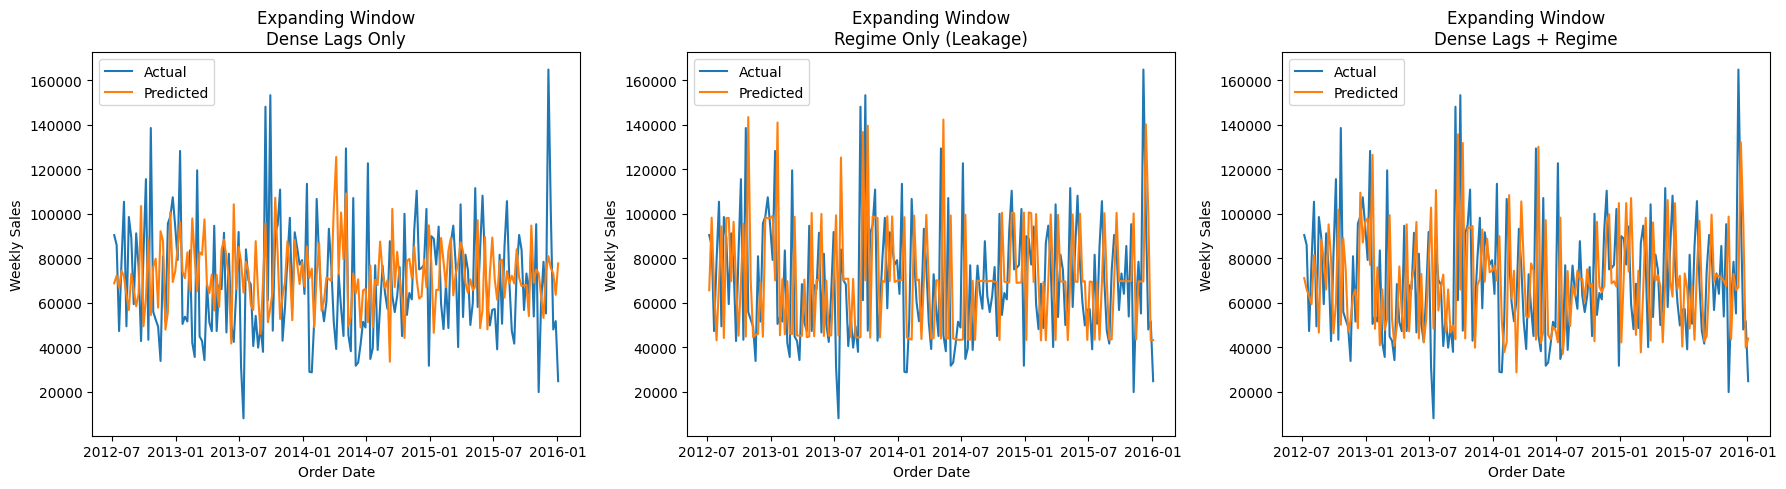

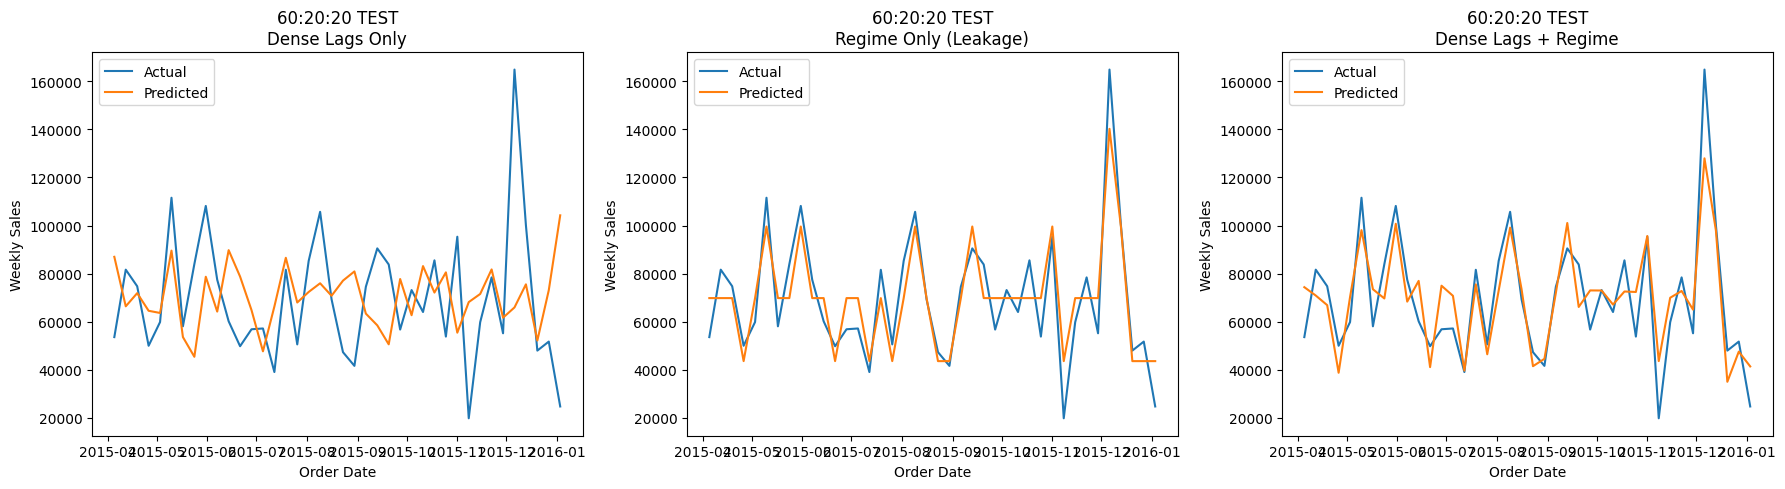

In [ ]:
## (b) Regime Label (Peak / High / Normal / Low / Trough) made available for weekly prediction 

# Review of visual plots

import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor

# ======================================================
# LOAD + WEEKLY AGGREGATION
# ======================================================
df = pd.read_csv("/home/surendran/rag_local/data/walmart Retail Data.csv")
df["Order Date"] = pd.to_datetime(df["Order Date"])
df = df.sort_values("Order Date")

weekly = (
    df.set_index("Order Date")
      .resample("W")["Sales"]
      .sum()
      .reset_index()
)

# ======================================================
# 🔴 GLOBAL REGIME LABEL (CATEGORICAL LEAKAGE)
# ======================================================
global_avg = weekly["Sales"].mean()

def assign_regime(x):
    ratio = (x - global_avg) / global_avg
    if ratio >= 0.75:
        return "PEAK"
    elif ratio >= 0.25:
        return "HIGH"
    elif ratio > -0.25:
        return "NORMAL"
    elif ratio > -0.75:
        return "LOW"
    else:
        return "TROUGH"

weekly["regime"] = weekly["Sales"].apply(assign_regime)
weekly = pd.get_dummies(weekly, columns=["regime"], drop_first=False)

# ======================================================
# LAG FEATURES
# ======================================================
lags = list(range(1, 14))

def make_lagged(df):
    out = df.copy()
    for lag in lags:
        out[f"lag_{lag}"] = out["Sales"].shift(lag)
    return out.dropna().reset_index(drop=True)

# ======================================================
# MODEL CONFIG
# ======================================================
xgb_params = {
    "n_estimators": 300,
    "max_depth": 3,
    "learning_rate": 0.05,
    "objective": "reg:squarederror",
    "random_state": 42
}

# ======================================================
# EXPANDING WINDOW PREDICTIONS
# ======================================================
def expanding_window_preds(df, feature_set):
    df = make_lagged(df)

    X = df[feature_set]
    y = df["Sales"]
    dates = df["Order Date"]

    preds, acts, dts = [], [], []

    for t in range(len(lags), len(df) - 1):
        model = XGBRegressor(**xgb_params)
        model.fit(X.iloc[:t], y.iloc[:t], verbose=False)

        preds.append(model.predict(X.iloc[t:t+1])[0])
        acts.append(y.iloc[t+1])
        dts.append(dates.iloc[t+1])

    return dts, acts, preds

# ======================================================
# 60:20:20 SPLIT PREDICTIONS
# ======================================================
def split_preds(df, feature_set):
    df = make_lagged(df)

    X = df[feature_set]
    y = df["Sales"]
    dates = df["Order Date"]

    n = len(df)
    t1, t2 = int(0.6*n), int(0.8*n)

    model = XGBRegressor(**xgb_params)
    model.fit(X.iloc[:t1], y.iloc[:t1], verbose=False)

    return {
        "Train": (dates.iloc[:t1], y.iloc[:t1], model.predict(X.iloc[:t1])),
        "Val":   (dates.iloc[t1:t2], y.iloc[t1:t2], model.predict(X.iloc[t1:t2])),
        "Test":  (dates.iloc[t2:], y.iloc[t2:], model.predict(X.iloc[t2:]))
    }

# ======================================================
# FEATURE SETS
# ======================================================
lag_features = [f"lag_{l}" for l in lags]
regime_features = [c for c in weekly.columns if c.startswith("regime_")]

features = {
    "Dense Lags Only": lag_features,
    "Regime Only (Leakage)": regime_features,
    "Dense Lags + Regime": lag_features + regime_features
}

# ======================================================
# PLOT — EXPANDING WINDOW
# ======================================================
plt.figure(figsize=(18, 5))

for i, (name, feats) in enumerate(features.items(), 1):
    dts, acts, preds = expanding_window_preds(weekly, feats)

    plt.subplot(1, 3, i)
    plt.plot(dts, acts, label="Actual")
    plt.plot(dts, preds, label="Predicted")
    plt.title(f"Expanding Window\n{name}")
    plt.xlabel("Order Date")
    plt.ylabel("Weekly Sales")
    plt.legend()

plt.tight_layout()
plt.show()

# ======================================================
# PLOT — 60:20:20 (TEST SET ONLY)
# ======================================================
plt.figure(figsize=(18, 5))

for i, (name, feats) in enumerate(features.items(), 1):
    split = split_preds(weekly, feats)
    dts, acts, preds = split["Test"]

    plt.subplot(1, 3, i)
    plt.plot(dts, acts, label="Actual")
    plt.plot(dts, preds, label="Predicted")
    plt.title(f"60:20:20 TEST\n{name}")
    plt.xlabel("Order Date")
    plt.ylabel("Weekly Sales")
    plt.legend()

plt.tight_layout()
plt.show()


==== 60:20:20 SPLIT ====
Baseline: {'MAE': 23037.398688281253, 'RMSE': np.float64(30158.59295254205)}
Joint Norm Leak: {'MAE': 46363.690809375, 'RMSE': np.float64(50993.38303813647)}

==== EXPANDING WINDOW ====
Baseline: {'MAE': 24164.92128620219, 'RMSE': np.float64(30813.23437275543)}
Joint Norm Leak: {'MAE': 24168.376569035616, 'RMSE': np.float64(30815.68819180876)}


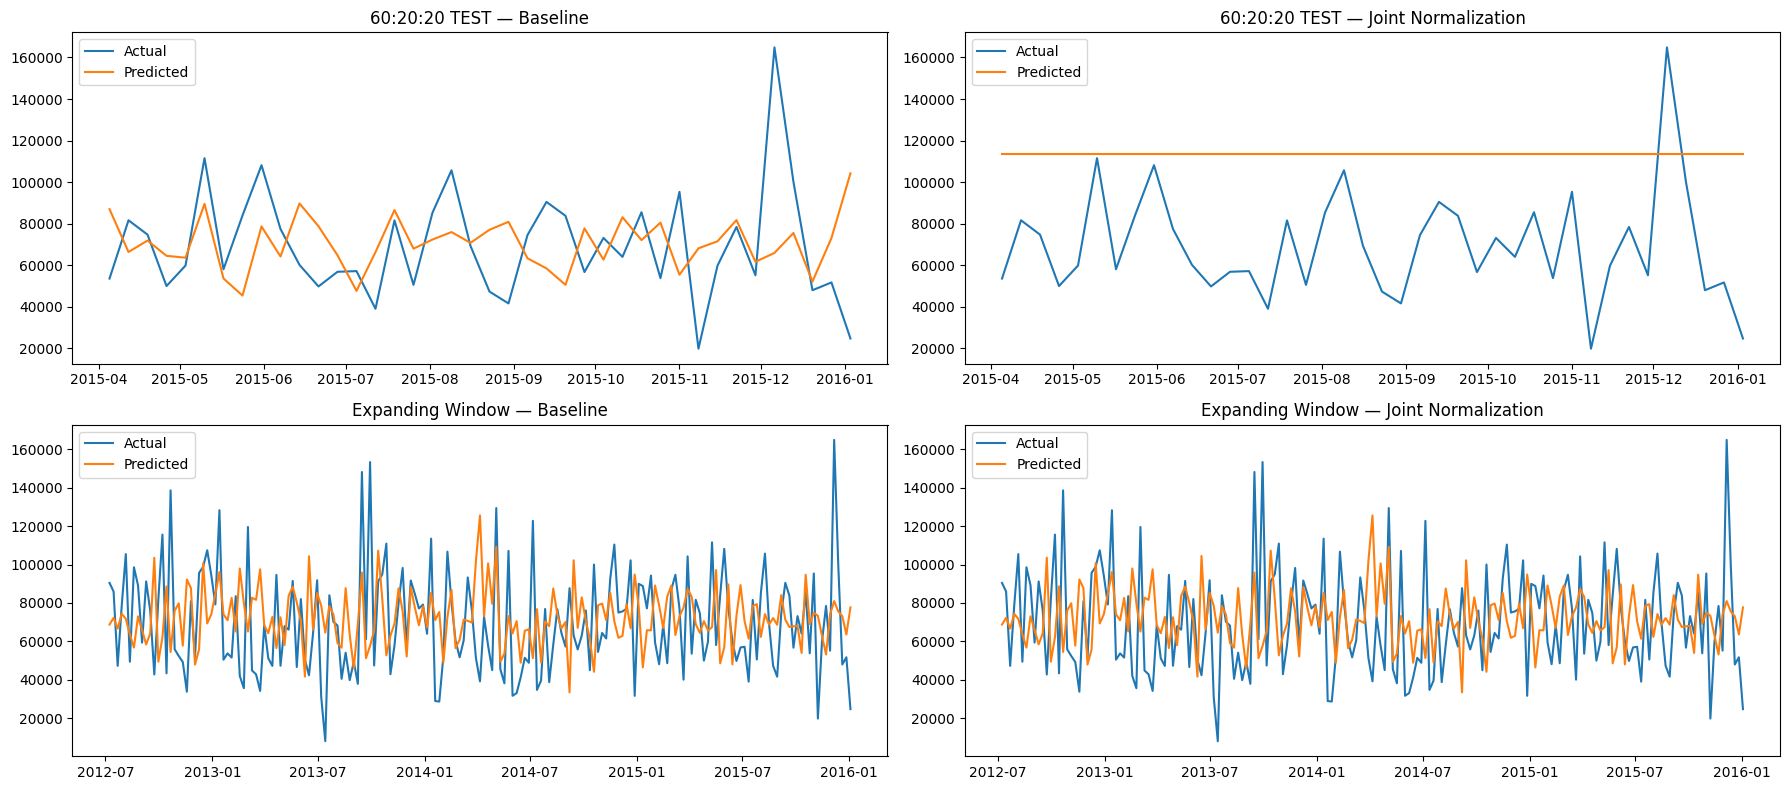

In [1]:
## (3) Joint normalization 

# Review of visual plots


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xgboost import XGBRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ======================================================
# LOAD + WEEKLY DATA
# ======================================================
df = pd.read_csv("/home/surendran/rag_local/data/walmart Retail Data.csv")
df["Order Date"] = pd.to_datetime(df["Order Date"])
df = df.sort_values("Order Date")

weekly = (
    df.set_index("Order Date")
      .resample("W")["Sales"]
      .sum()
      .reset_index()
)

# ======================================================
# LAG FEATURES
# ======================================================
lags = list(range(1, 14))

def make_lagged(df):
    out = df.copy()
    for lag in lags:
        out[f"lag_{lag}"] = out["Sales"].shift(lag)
    return out.dropna().reset_index(drop=True)

# ======================================================
# MODEL + METRICS
# ======================================================
xgb_params = {
    "n_estimators": 300,
    "max_depth": 3,
    "learning_rate": 0.05,
    "objective": "reg:squarederror",
    "random_state": 42
}

def mae_rmse(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    return mean_absolute_error(y_true, y_pred), np.sqrt(mse)

# ======================================================
# 60:20:20 SPLIT (WITH PLOTS)
# ======================================================
def split_60_20_20(df, normalize=False):
    df = make_lagged(df)

    features = [f"lag_{l}" for l in lags]
    X = df[features].to_numpy()
    y = df["Sales"].to_numpy().reshape(-1, 1)
    dates = df["Order Date"].to_numpy()

    n = len(df)
    t1, t2 = int(0.6*n), int(0.8*n)

    if normalize:
        x_scaler = StandardScaler()
        y_scaler = StandardScaler()
        X[:t2] = x_scaler.fit_transform(X[:t2])
        y[:t2] = y_scaler.fit_transform(y[:t2])

    model = XGBRegressor(**xgb_params)
    model.fit(X[:t1], y[:t1].ravel(), verbose=False)

    preds = model.predict(X[t2:]).reshape(-1, 1)
    if normalize:
        preds = y_scaler.inverse_transform(preds).ravel()
    else:
        preds = preds.ravel()

    actuals = df["Sales"].iloc[t2:].to_numpy()

    metrics = dict(zip(
        ["MAE", "RMSE"],
        mae_rmse(actuals, preds)
    ))

    return dates[t2:], actuals, preds, metrics

# ======================================================
# EXPANDING WINDOW (1-STEP)
# ======================================================
def expanding_window(df, normalize=False):
    df = make_lagged(df)

    features = [f"lag_{l}" for l in lags]
    X_full = df[features].to_numpy()
    y_full = df["Sales"].to_numpy()
    dates = df["Order Date"].to_numpy()

    preds, acts, dts = [], [], []

    for t in range(len(lags), len(df) - 1):
        X = X_full[:t]
        y = y_full[:t].reshape(-1, 1)

        if normalize:
            x_scaler = StandardScaler()
            y_scaler = StandardScaler()
            X = x_scaler.fit_transform(X)
            y = y_scaler.fit_transform(y)
            X_next = x_scaler.transform(X_full[t:t+1])
        else:
            X_next = X_full[t:t+1]

        model = XGBRegressor(**xgb_params)
        model.fit(X, y.ravel(), verbose=False)

        pred = model.predict(X_next)[0]
        if normalize:
            pred = y_scaler.inverse_transform([[pred]])[0, 0]

        preds.append(pred)
        acts.append(y_full[t+1])
        dts.append(dates[t+1])

    metrics = dict(zip(
        ["MAE", "RMSE"],
        mae_rmse(np.array(acts), np.array(preds))
    ))

    return dts, acts, preds, metrics

# ======================================================
# RUN + PRINT METRICS
# ======================================================
print("==== 60:20:20 SPLIT ====")
d_b, a_b, p_b, m_b = split_60_20_20(weekly, normalize=False)
d_n, a_n, p_n, m_n = split_60_20_20(weekly, normalize=True)

print("Baseline:", m_b)
print("Joint Norm Leak:", m_n)

print("\n==== EXPANDING WINDOW ====")
d2_b, a2_b, p2_b, m2_b = expanding_window(weekly, normalize=False)
d2_n, a2_n, p2_n, m2_n = expanding_window(weekly, normalize=True)

print("Baseline:", m2_b)
print("Joint Norm Leak:", m2_n)

# ======================================================
# PLOTS
# ======================================================
plt.figure(figsize=(18, 8))

# --- 60:20:20 TEST ---
plt.subplot(2,2,1)
plt.plot(d_b, a_b, label="Actual")
plt.plot(d_b, p_b, label="Predicted")
plt.title("60:20:20 TEST — Baseline")
plt.legend()

plt.subplot(2,2,2)
plt.plot(d_n, a_n, label="Actual")
plt.plot(d_n, p_n, label="Predicted")
plt.title("60:20:20 TEST — Joint Normalization")
plt.legend()

# --- Expanding Window ---
plt.subplot(2,2,3)
plt.plot(d2_b, a2_b, label="Actual")
plt.plot(d2_b, p2_b, label="Predicted")
plt.title("Expanding Window — Baseline")
plt.legend()

plt.subplot(2,2,4)
plt.plot(d2_n, a2_n, label="Actual")
plt.plot(d2_n, p2_n, label="Predicted")
plt.title("Expanding Window — Joint Normalization")
plt.legend()

plt.tight_layout()
plt.show()



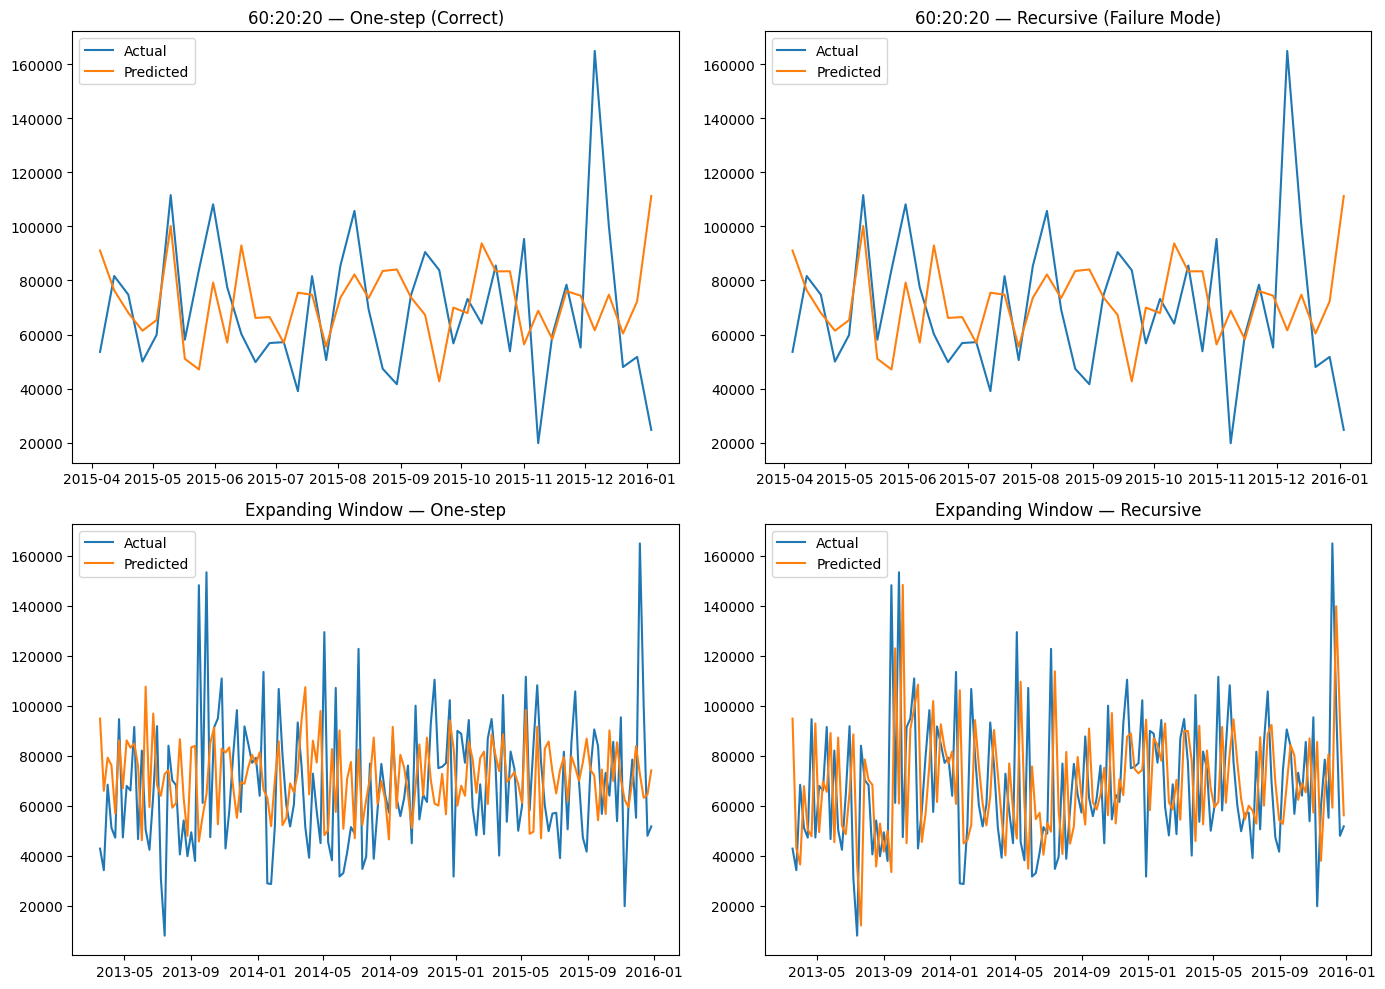

In [2]:
## (d) Recursive data fed incorrectly instead of actuals 

# Review of metrics


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error

# --------------------------------------------------
# Data preparation
# --------------------------------------------------
df = pd.read_csv("/home/surendran/rag_local/data/walmart Retail Data.csv")
df["Order Date"] = pd.to_datetime(df["Order Date"])

weekly = (
    df.groupby(pd.Grouper(key="Order Date", freq="W"))
      .agg({"Sales": "sum"})
      .reset_index()
      .sort_values("Order Date")
      .reset_index(drop=True)
)

# Dense lags
LAGS = list(range(1, 14))
for l in LAGS:
    weekly[f"lag_{l}"] = weekly["Sales"].shift(l)

weekly = weekly.dropna().reset_index(drop=True)

X_full = weekly[[f"lag_{l}" for l in LAGS]]
y_full = weekly["Sales"]
dates = weekly["Order Date"]

# --------------------------------------------------
# Model
# --------------------------------------------------
def make_model():
    return XGBRegressor(
        n_estimators=300,
        max_depth=3,
        learning_rate=0.05,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42
    )

# --------------------------------------------------
# 60:20:20 — One-step vs Recursive
# --------------------------------------------------
def split_forecast(recursive=False):
    n = len(X_full)
    t1, t2 = int(0.6*n), int(0.8*n)

    X_train, y_train = X_full.iloc[:t1], y_full.iloc[:t1]
    X_test,  y_test  = X_full.iloc[t2:], y_full.iloc[t2:]
    dates_test = dates.iloc[t2:]

    model = make_model()
    model.fit(X_train, y_train)

    preds = []
    X_running = X_full.copy()

    for i in range(t2, n):
        x = X_running.iloc[i:i+1]
        pred = model.predict(x)[0]
        preds.append(pred)

        if recursive:
            # feed prediction back
            for l in range(len(LAGS)-1, 0, -1):
                X_running.iloc[i, l] = X_running.iloc[i, l-1]
            X_running.iloc[i, 0] = pred

    return dates_test, y_test.values, np.array(preds)

# --------------------------------------------------
# Expanding window — One-step vs Recursive
# --------------------------------------------------
def expanding_forecast(recursive=False):
    preds, acts, dates_out = [], [], []
    X_running = X_full.copy()

    for t in range(50, len(X_full)-1):
        model = make_model()
        model.fit(X_running.iloc[:t], y_full.iloc[:t])

        x = X_running.iloc[t:t+1]
        pred = model.predict(x)[0]

        preds.append(pred)
        acts.append(y_full.iloc[t])
        dates_out.append(dates.iloc[t])

        if recursive:
            for l in range(len(LAGS)-1, 0, -1):
                X_running.iloc[t, l] = X_running.iloc[t, l-1]
            X_running.iloc[t, 0] = pred

    return np.array(dates_out), np.array(acts), np.array(preds)

# --------------------------------------------------
# Run forecasts
# --------------------------------------------------
d1, a1, p1 = split_forecast(recursive=False)
d2, a2, p2 = split_forecast(recursive=True)

d3, a3, p3 = expanding_forecast(recursive=False)
d4, a4, p4 = expanding_forecast(recursive=True)

# --------------------------------------------------
# Plots
# --------------------------------------------------
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.plot(d1, a1, label="Actual")
plt.plot(d1, p1, label="Predicted")
plt.title("60:20:20 — One-step (Correct)")
plt.legend()

plt.subplot(2,2,2)
plt.plot(d2, a2, label="Actual")
plt.plot(d2, p2, label="Predicted")
plt.title("60:20:20 — Recursive (Failure Mode)")
plt.legend()

plt.subplot(2,2,3)
plt.plot(d3, a3, label="Actual")
plt.plot(d3, p3, label="Predicted")
plt.title("Expanding Window — One-step")
plt.legend()

plt.subplot(2,2,4)
plt.plot(d4, a4, label="Actual")
plt.plot(d4, p4, label="Predicted")
plt.title("Expanding Window — Recursive")
plt.legend()

plt.tight_layout()
plt.show()
